# Dipy Simulations (DTI issue 2)

As I've learnt yesterday, reconstruction of different dMRI models in dipy are imported from “dipy.reconst”. For example, in the cells below, we review how one can fit DTI in a synthetic single voxel simulation.

### DTI in single tensor simulations

Let's simulate a single tensor signal (code explained in Simulated_DTI_issue_1).

In [1]:
import numpy as np
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import _check_directions, all_tensor_evecs, single_tensor

# Simulated diffusion-weighted acquisition parameters and GradientTable Reconstruction
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

bvecs = np.vstack((np.array([0, 0, 0]), hsph_updated.vertices))
bvals = np.ones(n_pts + 1) * 1000
bvals[0] = 0;

gtab = gradient_table(bvals, bvecs)

# Generate synthetic signals
AD_gt = 1.7e-3
RD_gt = 0.3e-3
angle = (-45.0, 0.0)
direction_gt = _check_directions([angle])
evals = np.array([AD_gt, RD_gt, RD_gt]);
evecs = all_tensor_evecs(direction_gt[0])

signal_single_tensor = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=None)

We can fit the DTI model to these synthetic signals in the following way:

In [2]:
from dipy.reconst.dti import TensorModel

# 1) define the DTI model according to GradientTable object 
dti_model = TensorModel(gtab)

# 2) fitting the defined the DTI model
dti_fit = dti_model.fit(signal_single_tensor)

From fitted object you can retrieve the diffusion tensor and DTI metrics

In [3]:
from dipy.viz import window, actor
from dipy.data import get_sphere

sphere = get_sphere('repulsion724')

evals4D = np.array([[[dti_fit.evals]]])
evecs4D = np.array([[[dti_fit.evecs]]])

color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, :] = np.abs(direction_gt);  # color coded

scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, sphere=sphere, scalar_colors=color4D, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='single_tensor_voxel_fit.png', size=(600, 600))

print("MD = {} mm2/s".format(dti_fit.md))
print("AD = {} mm2/s".format(dti_fit.ad))
print("RD = {} mm2/s".format(dti_fit.rd))
print("FA = {}".format(dti_fit.fa))

C:\Users\rafae\anaconda3\envs\dipy_release\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


MD = 0.0007666666666666672 mm2/s
AD = 0.0017000000000000014 mm2/s
RD = 0.00030000000000000024 mm2/s
FA = 0.7990222037494894


Yesterday, I've showed that DTI provides limited angular information to resolve more than one main tissue direction, and thus several high angular resolution diffusion imaging techniques have been discussed to resolve the directions of complex fibre organizations (e.g. crossing fibres).

Today we will show that, in addition to the limited angular information, DTI provides limited information of microstructural alterations since this cannot capture tissue non-Gaussian diffusion effects. Then different dMRI models that considers that non-Gaussian diffusion nature will be introduced.

### Simulations of non-Gaussian diffusion signals of single fibre populations

As I've mentioned yesterday, diffusion in biological tissues present non-Gaussian diffusion properties because: 1) tissue present multiple compartments with their own apparent diffuvisity values; 2) water molecules interact with tissue boundaries.

Ignoring the non-Gaussian properties that rises from the interaction of diffusing water molecules with tissue boundaries, a single way to introduce non-Gaussian diffusion on simulations of single fibre population is to represent then as a sum of multiple compartments. For example, below we represent a single fibre population as a sum of two compartments (example less assume that these compartments reflets different diffusivities in the intra- and extra-cellular spaces).


In [4]:
# diffusion tensor main direction
fangle = (45.0, 0.0)
fdirection = _check_directions([fangle])

ADi = 1e-3
ADe = 2.3e-3
RDi = 0.1e-3
RDe = 0.8e-3

# Reconstruct the eigenvalues of the diffusion tensor
evals1 = [ADi, RDi, RDi]
evals2 = [ADe, RDe, RDe]

# Volume water fraction of the intra-cellular space
f = 0.5

# Sample eigenvectors from diffusion tensor main direction
evecs = all_tensor_evecs(fdirection[0])

Let's plot the diffusion tensors of these two fiber populations

In [5]:
# Color of the tensor is defined according to tensor main direction
evals4D = np.array([[[evals1, evals2]]])
evecs4D = np.array([[[evecs, evecs]]])

color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, 0] = 1   # red colour coded
color4D[0, 0, 1, 2] = 1   # blue colour coded

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='multi_tensor_voxel_gt.png', size=(600, 600))

For generation of these signals, let's consider the acquisition of 5 non-zero b-values from 500 to 2500.

In [6]:
directions = hsph_updated.vertices  # Each b-value is simulated for the 60 directions

bvals = np.hstack((np.zeros(1), 500 * np.ones(n_pts),
                   1000 * np.ones(n_pts), 1500 * np.ones(n_pts),
                   2000 * np.ones(n_pts), 2500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((1, 3)), directions, directions, 
                   directions, directions, directions))

gtab = gradient_table(bvals, bvecs)

In [7]:
from dipy.sims.voxel import multi_tensor

mevals = [evals1, evals2]
angles = [fangle, fangle]
S0 = 1
fractions = [50, 50]
signal, st = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

Let's now fit DTI model to these synthetic signals

In [8]:
dti_model = TensorModel(gtab)
dti_fit = dti_model.fit(signal)

Since its only fit a single diffusion tensor, DTI estimated tensor should be considered as the averaged of the two compartment tensors in which ground truth eigenvalues can be computed by:

In [9]:
evals_gt = f*np.array(evals1) + (1-f)*np.array(evals2)

Let's plot the total ground truth diffusion tensor and DTI fitted diffusion tensor.

In [10]:
evals4D = np.array([[[dti_fit.evals, evals_gt]]])
evecs4D = np.array([[[dti_fit.evecs, evecs]]])

color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, :] = np.abs(fdirection);  # color coded
color4D[0, 0, 1, :] = np.abs(fdirection);  # color coded

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='mvoxel_tensor_fit_vs_gt.png', size=(600, 600))

Since the two compartments are aligned to each other, the fitted total diffusion tensor main direction will correspond to the main direction of the ground truth tensor. However, its shape is different to the ground truth total tensor, as we can confirm by looking to the eigenvalues:

In [11]:
print("The ground truth eigenvalues are = {}".format(evals_gt))
print("The fitted eigenvalues are = {}".format(dti_fit.evals))

The ground truth eigenvalues are = [0.00165 0.00045 0.00045]
The fitted eigenvalues are = [0.00132927 0.0002881  0.00028809]


These discrepancies can be explained by the non-Gaussian diffusion effect not considered on DTI model - in this case rising from the presence of compartments with different diffusivities. Indeed, one can confirm that DTI fails to fit the ground truth dMRI signal decays by plotting the ground truth and fitted log signal decays as a function of the b-value. For this let’s select the signal decays of a single direction measured at different b-values:

In [12]:
select_dir = np.hstack((np.zeros(1, dtype=int), np.arange(1, 60*5, 60)))
b_sel = gtab.bvals[select_dir]
logs_sel = np.log(signal[select_dir])

The DTI signal prediction can be retrieved from "dti_fit" attribute "predict". Below let's plot the selected ground truth and DTI's predicted signals:

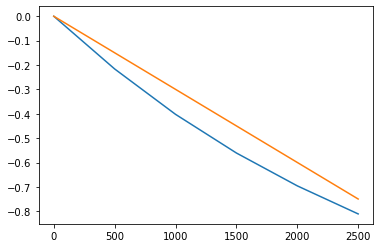

In [13]:
import matplotlib.pyplot as plt

signal_pred = dti_fit.predict(gtab, S0=1)

logs_pred = np.log(signal_pred[select_dir])

plt.plot(b_sel, logs_sel)
plt.plot(b_sel, logs_pred)

For the figure above, we show that the ground truth signal (blue line) does not follow a linear b-value decay as assumed by DTI (blue line) ($log(S/S_0)=-bD(n)$), and thus DTI fails to represent the generated synthetic signals. 


As it is shown below, quantifying the degree of non-Gaussian diffusion (i.e. the degree that the log signals decays deviate from a linear decay) can provide important information of tissue microstructure.

### Diffusion Kurtosis Imaging

Diffusion Kurtosis Imaging (DKI) is an expansion of DTI. In addition to the diffusion tensor, DKI estimates the diffusional kurtosis tensor - a 4th order tensor that quantifies the degree of non-Gaussian diffusion in a model free manner.

Below we use Dipy to fit DKI on the synthetic signals of the fibre represented by its intra- and extra-cellular spaces.

In [14]:
from dipy.reconst.dki import DiffusionKurtosisModel

dki_model = DiffusionKurtosisModel(gtab)
dki_fit = dki_model.fit(signal)

Below we plot the ground truth and DKI predicted signals of the selected diffusion gradient directions.

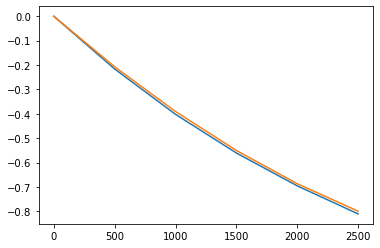

In [15]:
signal_pred = dki_fit.predict(gtab, S0=1)

logs_pred = np.log(signal_pred[select_dir])

plt.plot(b_sel, logs_sel)
plt.plot(b_sel, logs_pred)

The figure below shows that, in opposite to DTI, DKI is able to model the non-linear behaviour of the log-signal decay with b-value.

Below we plot diffusion tensor ground truth, diffusion tensor estimated from DTI, and diffusion tensor from DKI.

In [16]:
evals4D = np.array([[[evals_gt, dti_fit.evals, dki_fit.evals]]])
evecs4D = np.array([[[evecs, dti_fit.evecs, dki_fit.evecs]]])

color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, :] = np.abs(fdirection);  # color coded
color4D[0, 0, 1, :] = np.abs(fdirection);  # color coded
color4D[0, 0, 2, :] = np.abs(fdirection);  # color coded

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='mvoxel_tensor_dti_dki_and_gt.png', size=(600, 600))

In the above figure, one can see that DKI provides a diffusion tensor estimate that better approaches the ground truth diffusion tensor. Thus, DKI is shown to provide more accurate estimates of the diffusin tensor than compared with DTI. Let's check that from the tensor eigenvalues:

In [17]:
print("The ground truth eigenvalues are = {}".format(evals_gt))
print("The fitted eigenvalues by DTI are = {}".format(dti_fit.evals))
print("The fitted eigenvalues by DKI are = {}".format(dki_fit.evals))

The ground truth eigenvalues are = [0.00165 0.00045 0.00045]
The fitted eigenvalues by DTI are = [0.00132927 0.0002881  0.00028809]
The fitted eigenvalues by DKI are = [0.00159013 0.00042472 0.00042471]


In addition to the diffusion tensor, DKI also estimates the kurtosis tensor. A visual interpretation of the kurtosis tensor can be obtaining by plotting the 3D dependency of kurtosis directinal values. This can be done in the following way (Note, we add the fibre main direction on this figure for a reference):

In [18]:
akc = dki_fit.akc(sphere)

scene = window.Scene()
dki_actor = actor.odf_slicer(np.array([[[akc]]]), sphere=sphere, scale=1)
scene.add(actor.peak_slicer(np.array([[[fdirection]]]),
                            np.array([[[dki_fit.fa]]]),
                            colors=None))
scene.add(dki_actor)


window.show(scene)

window.record(scene, n_frames=1, out_path='mvoxel_tensor_kurtosis_tensor.png', size=(600, 600))

The figure below shows that kurtosis present higher values perpendicularly to fibres. This is expected for this simulation since the diffusivity variances are higher in the radial directions than in axial directions.

From DKI several metrics can be extracted as the mean kurtosis (MK), axial kurtosis (AK) and radial kurtosis (RK). Note that since the diffusion tensor is also fitted, DKI can be used also to compute standard diffusion metrics such as MD, AD, RD, FA.  Let's print these metrics for the above simulations.

In [19]:
print("DKI MD (mm^2/s) = {}".format(dki_fit.md))
print("DKI AD (mm^2/s) = {}".format(dki_fit.ad))
print("DKI RD (mm^2/s) = {}".format(dki_fit.rd))
print("DKI FA = {}".format(dki_fit.fa))
print("DKI MK = {}".format(dki_fit.mk()))
print("DKI AK = {}".format(dki_fit.ak()))
print("DKI RK = {}".format(dki_fit.rk()))

DKI MD (mm^2/s) = 0.0008131867090952232
DKI AD (mm^2/s) = 0.001590132056847703
DKI RD (mm^2/s) = 0.00042471403521898336
DKI FA = 0.6856249522652779
DKI MK = 0.8602404244725701
DKI AK = 0.3376867322876117
DKI RK = 1.5431982511382993


### DKI in crossing fibres

Below we show that the kurtosis tensor can provide information of crossing fibres. For this let's consider fibers with two different media (representing intra and extra-cellular media), a total of four components have to be taken in to account (i.e. the first two compartments correspond to the intra and extra cellular media for the first fiber population while the others correspond to the media of the second fiber population):

In [20]:
mevals = np.array([[ADi, RDi, RDi], [ADe, RDe, RDe],
                   [ADi, RDi, RDi], [ADe, RDe, RDe]])

To simulate crossing fibers at $70^{o}$ the compartments of the first fiber are aligned to the X-axis while the compartments of the second fiber are aligned to the X-Z plane with an angular deviation of $70^{o}$ from the first one.

In [21]:
angles = [(90, 0), (90, 0), (20, 0), (20, 0)]

direction_gt1 = _check_directions([(90, 0)])
direction_gt2 = _check_directions([(20, 0)])

In fractions we save the percentage of the contribution of each compartment, which is computed by multiplying the percentage of contribution of each fiber population (in this case let's assume same contribution, i.e. fp = 50%) and the water fraction of each different medium (previously saved in variable f):

In [22]:
fp = 50 
fractions = [f*fp, (1 - f)*fp, f*fp, (1 - f)*fp]

Let's now generate the signal of these crossing fibre system.

In [23]:
signal_cross, st = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

Below we fit and plot the kurtosis tensor for these system

In [24]:
dki_fit = dki_model.fit(signal_cross)

akc = dki_fit.akc(sphere)

scene = window.Scene()
dki_actor = actor.odf_slicer(np.array([[[akc]]]), sphere=sphere, scale=1)
scene.add(actor.peak_slicer(np.array([[[direction_gt1]]]),
                            np.array([[[dki_fit.mk()]]]),
                            colors=None))
scene.add(actor.peak_slicer(np.array([[[direction_gt2]]]),
                            np.array([[[dki_fit.mk()]]]),
                            colors=None))
scene.add(dki_actor)


window.show(scene)

window.record(scene, n_frames=1, out_path='kurtosis_tensor_of_crossing_fibres.png', size=(600, 600))

The 3D kurtosis geometry show to present maximum kurtosis values across the directions of the two ground truth values. Although, in this workshop, I will focus on the information of DKI metrics if you are interested in performing DKI-based tractography please give a look to [Henriques et al., 2015](https://www.sciencedirect.com/science/article/pii/S1053811915000968) and don't hesitate in contacting me.

### Why quantifying non-Gaussian diffusion may be relevant?

In some studies, we may be interested in using dMRI to quantify tissue maturation or degeneration. For this, it is common to use the fractional anisotropy estimates from the diffusion tensor. However, fa values may be confounded by alteration of the degree of fibre dispersion  and crossing. To study the dependency of FA to tissue degeneration (which here we models as an alteration on the intra-cellular water volume fraction) and the intersection angle of two crossing fibre, let's repeat the multi tensor simulations with different ground truth f values and different ground truth fibre directions. 

In [25]:
# Array containing the intra-cellular volume fractions tested
f = np.linspace(30, 70.0, num=5)

# Array containing the intersection angle
ang = np.linspace(0, 90.0, num=91)

# Matrix where synthetic signals will be stored
dwi = np.empty((f.size, ang.size, bvals.size))

for f_i in range(f.size):
    # estimating volume fractions for individual tensors
    fractions = np.array([100 - f[f_i], f[f_i], 100 - f[f_i], f[f_i]]) * 0.5

    for a_i in range(ang.size):
        # defining the directions for individual tensors
        angles = [(ang[a_i], 0.0), (ang[a_i], 0.0), (0.0, 0.0), (0.0, 0.0)]

        # producing signals using Dipy's function multi_tensor
        signal, sticks = multi_tensor(gtab, mevals, S0=100, angles=angles,
                                      fractions=fractions, snr=None)
        dwi[f_i, a_i, :] = signal

Now that the synthetic signals were produced, we can go forward with DKI fitting to extract FA estimates.

In [26]:
dki_fit = dki_model.fit(dwi)
fa = dki_fit.fa

Now we plot the FA results as a function of the ground truth intersection angle and for different volume fractions of intra-cellular water.

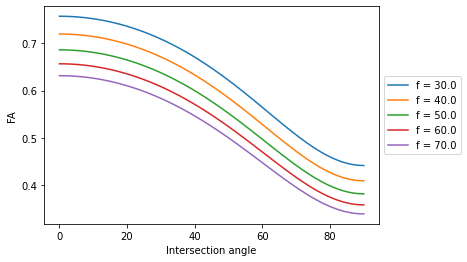

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1)

for f_i in range(f.size):
    axs.plot(ang, fa[f_i], label='f = {}'.format(f[f_i]))
axs.set_xlabel('Intersection angle')
axs.set_ylabel('FA')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The above figure shows that FA varies more with alterations on intersection angle than on the alteration of axonal water fraction.

Now let's repeat this plot for estimates of MK:

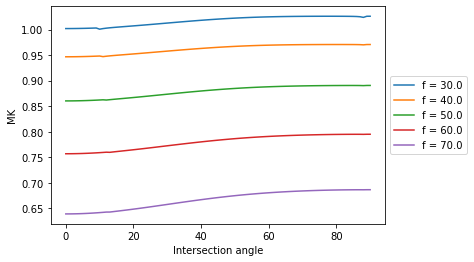

In [28]:
mk = dki_fit.mk()

fig, axs = plt.subplots(nrows=1, ncols=1)

for f_i in range(f.size):
    axs.plot(ang, mk[f_i], label='f = {}'.format(f[f_i]))
axs.set_xlabel('Intersection angle')
axs.set_ylabel('MK')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We above figure shows that MK varies more with alterations on microstructural parameters such as the axonal water fraction.

### Mean Signal Diffusion Kurtosis Imaging

Since the estimation of kurtosis is performed from the b-value dependence instead from the information captured by different directions, non-Gaussian information can be estimated even if we average the signals for different directions.

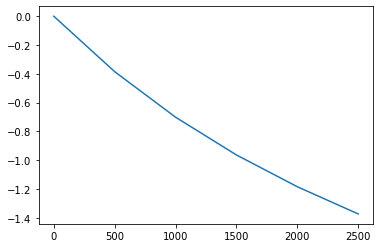

In [32]:
from dipy.reconst.msdki import mean_signal_bvalue
from dipy.core.gradients import unique_bvals_magnitude

mevals = [evals1, evals2]
angles = [fangle, fangle]
S0 = 1
fractions = [50, 50]
signal, st = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

msignal, ng = mean_signal_bvalue(signal, gtab)
ub = unique_bvals_magnitude(gtab.bvals)

plt.plot(ub, np.log(msignal))

Mean Signal Diffusion Kurtosis Imaging (MSDKI) is an adapted version of DKI. Instead of fitting a full kurtosis tensor, MSDKI estimates a scalar kurtosis quantity from the signal decays averaged across different diffusion directions [NetoHe2018](https://www.repository.cam.ac.uk/handle/1810/281993). Since these averaged signals are known to be independent to the fibre orientation distribution function, estimates from MSDKI are expected to be completed independent to fibre dispersion or crossing. Let's run the above signals for these model:

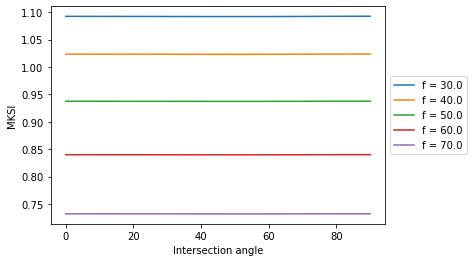

In [33]:
from dipy.reconst.msdki import MeanDiffusionKurtosisModel

msdki_model = MeanDiffusionKurtosisModel(gtab)
msdki_fit = msdki_model.fit(dwi)
mski = msdki_fit.msk

fig, axs = plt.subplots(nrows=1, ncols=1)

for f_i in range(f.size):
    axs.plot(ang, mski[f_i], label='f = {}'.format(f[f_i]))
axs.set_xlabel('Intersection angle')
axs.set_ylabel('MKSI')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))